# Model Training

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [27]:
import sys
sys.path.insert(0, '/Users/coconut/Desktop/zach/GA/Submissions/')
import eda

In [28]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12.0, 8.0)

## MLR

In [29]:
models = []
rmse_scores = []

### Data Preprocesing

In [30]:
# Load data
train = pd.read_csv('../datasets/clean/train_engineered.csv')

# Set features and target
X = train._get_numeric_data().drop(columns='SalePrice')
y = train['SalePrice']

# Save column names
features = list(X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 18)

# Scale data
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [31]:
# Baseline RMSE
# Train
rmse_train = round((sum((y - y_train.mean())**2 for y in y_train) / len(y_train))**0.5, 0)
print(f'RMSE baseline training: {rmse_train}')

# Test
rmse_test = round((sum((y - y_test.mean())**2 for y in y_test) / len(y_test))**0.5, 0)
print(f'RMSE baseline test: {rmse_test}')

RMSE baseline training: 79144.0
RMSE baseline test: 79660.0


**Interpretation:** RMSE score is used for the baseline model as this is the metric I will optimize for the production model.  
Baseline score is approximately \\$79,000, which is achieved by predicting the mean price of the dataset for every observation. The production model should improve on this RMSE score.

---
**Model iterations**

## LinearRegression

### Train

In [32]:
# Create model
model = LinearRegression()

# Cross validation
cval_score = cross_val_score(model, X_train, y_train).mean()
print(f'Cross validation score: {round(cval_score, 3)}')

# Fit the model on training data
model.fit(X_train, y_train)

Cross validation score: 0.912


LinearRegression()

### Evaluate

In [33]:
R2_train = round(model.score(X_train, y_train), 4)
R2_test = round(model.score(X_test, y_test), 4)

print(f"R2 train: {R2_train}")
print(f"R2 test: {R2_test}")

R2 train: 0.9462
R2 test: 0.9298


In [34]:
# RMSE train
rmse_train = round(metrics.mean_squared_error(y_train, model.predict(X_train), squared=False), 0)
print(f'RMSE training: {rmse_train}')

# RMSE test
rmse_test = round(metrics.mean_squared_error(y_test, model.predict(X_test), squared=False), 0)
print(f'RMSE test: {rmse_test}')

RMSE training: 18351.0
RMSE test: 21106.0


In [35]:
models.append('MLR')
rmse_scores.append(rmse_test)

**Findings:** Both train and test RMSE are big improvements over the baseline model.  
Cross validation score and train/test R2 are close in value; the random split is valid. R2 scores imply reasonably low variance, but the RMSE scores show signs of an overfit model.

## Visualize

Standard deviation of residuals: 21130.0


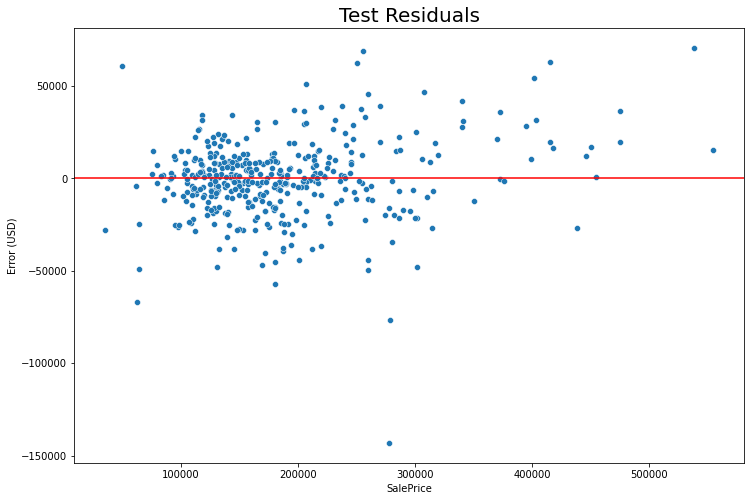

In [36]:
resids = y_test - model.predict(X_test)
sns.scatterplot(x = y_test, y = resids)
plt.title('Test Residuals', size=20)
plt.ylabel('Error (USD)')
plt.axhline(0, color='r');

print("Standard deviation of residuals:", round(resids.std(), 0))

**Interpretation:** Residuals are approximately of equal variance across each sale price for sale price < 300,000. Above this price there is a noticable curve upwards in the residuals, trending towards larger positive residuals as sale price increases past 300,000. More polynomial features may be a good approach to fit the model to this shape. Outlier residual ~ -150,000 - After much investigation I could not figure out which feature or combination of features is causing this massive failure in the model.

Standard deviation of residuals: 18357.0


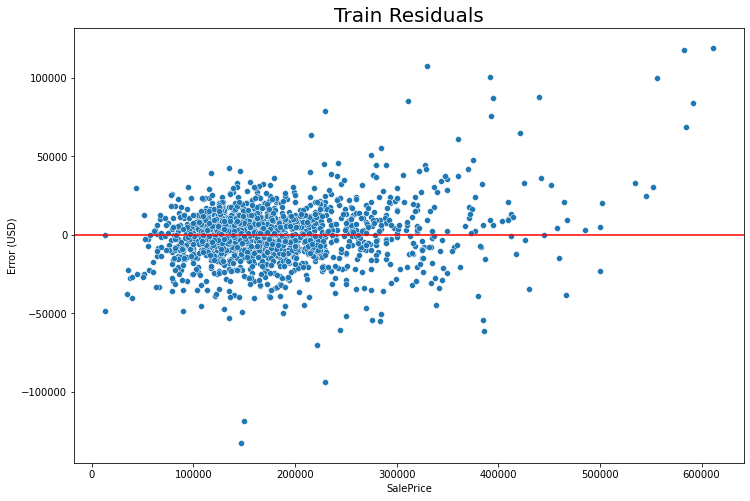

In [37]:
resids = y_train - model.predict(X_train)
sns.scatterplot(x = y_train, y = resids)
plt.title('Train Residuals', size=20)
plt.ylabel('Error (USD)')
plt.axhline(0, color='r');

print("Standard deviation of residuals:", round(resids.std(), 0))

**Interpretation:** Residuals of the training dataset display the same upward curve as is observed in the test data residuals. 2 outliers of residuals < -100,000 stand out in this dataset. 

---
## Ridge Regression

### Scale data and train model

In [38]:
# Create list of alphas
r_alphas = np.logspace(0, 5, 100)

# Cross-validate over ridge alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# Fit model using best ridge alpha
ridge_cv.fit(Z_train, y_train);

In [39]:
# Cross validation score
cval_score = ridge_cv.score(Z_train, y_train)
print(f'Cross validation score: {round(cval_score, 3)}')

Cross validation score: 0.944


**Interpretation:** Cross validation score is higher than for the olr model.

## Evaluate

In [40]:
R2_train = round(ridge_cv.score(Z_train, y_train), 4)
R2_test = round(ridge_cv.score(Z_test, y_test), 4)

print(f"R2 train: {R2_train}")
print(f"R2 test: {R2_test}")

R2 train: 0.944
R2 test: 0.9306


In [41]:
# RMSE train
rmse_train = round(metrics.mean_squared_error(y_train, ridge_cv.predict(Z_train), squared=False), 0)
print(f'RMSE training: {rmse_train}')

# RMSE test
rmse_test = round(metrics.mean_squared_error(y_test, ridge_cv.predict(Z_test), squared=False), 0)
print(f'RMSE test: {rmse_test}')

RMSE training: 18729.0
RMSE test: 20988.0


In [42]:
models.append('Ridge')
rmse_scores.append(rmse_test)

**Findings:** Cross val, train and test R2 are approxiately equal. RMSE score shows signs of overfitting.

## Visualize

Standard deviation of residuals: 21007.0


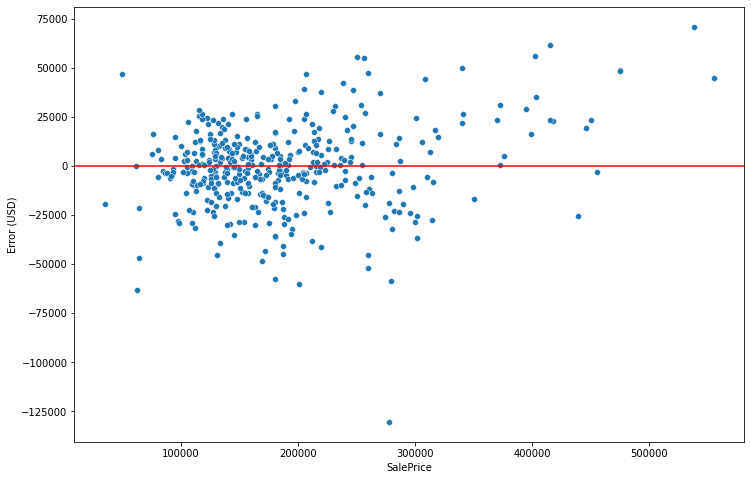

In [43]:
resids = y_test - ridge_cv.predict(Z_test)
sns.scatterplot(x = y_test, y = resids)
plt.ylabel('Error (USD)')
plt.axhline(0, color='r');

print("Standard deviation of residuals:", round(resids.std(), 0))

**Interpretation:** Residuals display the same upward curve as is observed in the mlr model's residuals.

## Lasso Regression

### Train

In [44]:
# Set up a list of Lasso alphas to check
l_alphas = np.logspace(-3, 0, 100)

# Cross-validate over Lasso alphas
lasso_cv = LassoCV(alphas=l_alphas, cv=5)

# Fit model using best ridge alpha
lasso_cv.fit(Z_train, y_train);

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123215660616.78656, tolerance: 841994812.6131649
  tol, rng, random, positive)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17622342517.527832, tolerance: 841994812.6131649
  tol, rng, random, positive)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18003569530.219666, tolerance: 841994812.6131649
  tol, rng, random, positive)
/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarnin

In [45]:
# Cross validation score
cval_score = lasso_cv.score(Z_train, y_train)
print(f'Cross validation score: {round(cval_score, 3)}')

Cross validation score: 0.946


**Interpretation:** Best cross validation score.

## Evaluate

In [46]:
R2_train = round(lasso_cv.score(Z_train, y_train), 4)
R2_test = round(lasso_cv.score(Z_test, y_test), 4)

print(f"R2 train: {R2_train}")
print(f"R2 test: {R2_test}")

R2 train: 0.9462
R2 test: 0.9297


In [47]:
# RMSE train
rmse_train = round(metrics.mean_squared_error(y_train, lasso_cv.predict(Z_train), squared=False), 0)
print(f'RMSE training: {rmse_train}')

# RMSE test
rmse_test = round(metrics.mean_squared_error(y_test, lasso_cv.predict(Z_test), squared=False), 0)
print(f'RMSE test: {rmse_test}')

RMSE training: 18352.0
RMSE test: 21123.0


In [48]:
models.append('Lasso')
rmse_scores.append(rmse_test)

**Interpretation:** Highest cross val and train R2 score, yet the rest R2 score is lacking. Same story in the RMSE train/test scores. Model is overfit.

## Visualize

Standard deviation of residuals: 21147.0


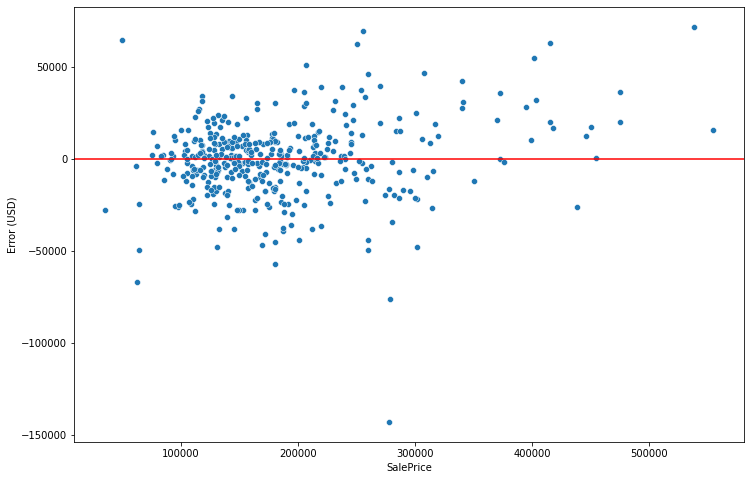

In [49]:
resids = y_test - lasso_cv.predict(Z_test)
sns.scatterplot(x = y_test, y = resids)
plt.ylabel('Error (USD)')
plt.axhline(0, color='r');

print("Standard deviation of residuals:", round(resids.std(), 0))

**Interpretation:** Residuals display the same upward curve as is observed in the mlr model's residuals.

# Compare Models

In [50]:
for model,rmse in zip(models, rmse_scores):
    print(f'{model}: {rmse}')

MLR: 21106.0
Ridge: 20988.0
Lasso: 21123.0


**Interpretation:** Similar performance accross models. I will use the OLR model because it is preferable for inference.